## Overview and Data Description:
* In this notebook, I will work on a 50,000 instance movie-data to perform sentiment analysis using two approaches.

> * Using a pre-trained sentiment-analysis transformer-based model.
        Using a classical Machine Learning classification model.
* IMDB dataset is a dataset for binary sentiment classification with two columns named:

> * review : for the text review message.
>  * sentiment : as a label column classifies the review as either positive or negative.


In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

sns.color_palette("husl", 8)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../dataset/IMDB Dataset.csv")

In [20]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=stopwords.words('english')

### General Exploration:
* Here, I have did a quick general exploration, class-distribution visualization , and general cleaning ,"I have payed attention not to do any detailed cleaning that may be wrong before train-test splitting".

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
df['review'].duplicated().sum()

418

In [8]:
df_new = df.drop_duplicates()
df_new.duplicated().sum()

0

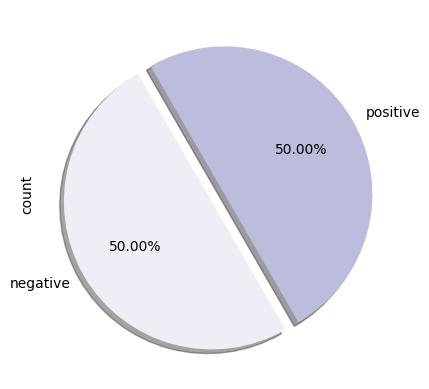

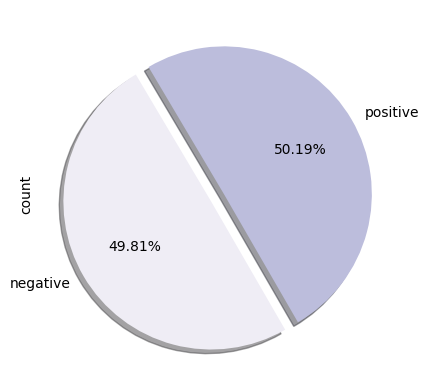

In [10]:
df['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',shadow=True, startangle=300, colors = ["#bcbddc", "#efedf5"])
plt.show()
df_new['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',shadow=True, startangle=300, colors = ["#bcbddc", "#efedf5"])
plt.show()

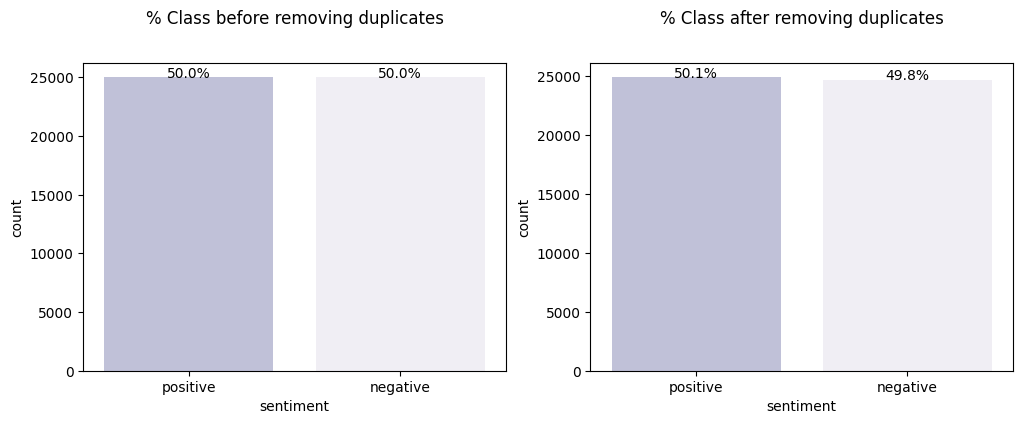

In [13]:
def prcentage_count_plot_comparison(col1, df1, col2, df2, mod):

    """
    A function to compare the binary class column distribution before and after certain modification.
        
    Arguments:
        col1: str | non-modified class column
        df1 : pd.DataFrame | dataframe of the non-modified class column
        col2: str | modified class column
        df2 : pd.DataFrame | dataframe of the modified class column
        mod : str | modification type

    Returns:
        Two axes plot of comparison.         
    """
    
    plt.figure(figsize = (12,4))

    plt.subplot(121)
    ax1 = sns.countplot(x = col1 , data =df1, palette=["#bcbddc", "#efedf5"])
    plt.title(f"% Class before {mod}",y=1.1)

    plt.subplot(122)
    ax2 = sns.countplot(x = col2 , data =df2, palette=["#bcbddc", "#efedf5"])
    plt.title(f"% Class after {mod}",y=1.1)



    # Annotating the percentages:

    for ax,dfs in zip([ax1, ax2],[df1, df2]):
        for p in ax.patches:
            height = p.get_height() - +20
            width = p.get_width()
            ax.text(
                p.get_x() + width / 2.,
                height,
                f'{height / len(dfs) * 100:.1f}%',
                ha="center")



    return plt.show()
prcentage_count_plot_comparison(col1='sentiment', df1=df , col2='sentiment',df2=df_new, mod='removing duplicates')


### Data splitting and cleaning for modeling analysis:
* 1. Shuffling & Train_Test_split:
 I didn't use the shuffling built-in parameter in train_test_split in order not to     exposed to index-change issues.


## Data Cleaning

In [16]:
class DataCleaning:
    
    replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let's": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"don't" : 'do not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"=" : ' ',
                r'<br />': ' ',
                r"\.+" : '.',
                r'\!+': ' ',
                r'\?+': ' ',
                r'\s+': ' '
                }
    
    def convert_normal_form(self, text : str) -> str:
        for i in self.replace_list:
            text = text.replace(i,self.replace_list[i])
        return text
    
    # Remove special characters
    def remove_special_characters(self, text : str) -> str:
        pattern=r'[^a-zA-z0-9\s]'
        text=re.sub(pattern,'',text)
        return text
    
    # Stemming
    def stemmer(self, text : str) -> str:
        ps=PorterStemmer()
        text= ' '.join([ps.stem(word) for word in text.split()])
        return text
    
    # Removing the stopwords
    def remove_stopwords(self, text : str) -> str:
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    def denoise_text(self, text : str) -> str:
        text = self.convert_normal_form(text)
        text = self.remove_special_characters(text)
        text = self.stemmer(text)
        text = self.remove_stopwords(text)
        return text
    
data_cleaning = DataCleaning()

df_new['review'] = df_new['review'].apply(lambda x : data_cleaning.denoise_text(x))
df_new.head()
    

,review,sentiment
0,one review ha mention watch 1 oz episod hook r...,positive
1,wonder littl product film techniqu veri unassu...,positive
2,thought thi wa wonder way spend time hot summe...,positive
3,basic famili littl boy jake think zombi hi clo...,negative
4,petter mattei love time money visual stun film...,positive


In [21]:
# shuffling the data:

np.random.seed(22)
shuffled_indices = np.random.permutation(df_new.index)
shuffled_df = df_new.loc[shuffled_indices].reset_index(drop=True)
shuffled_df

,review,sentiment
0,rent thi todayheard lot good review beforehand...,negative
1,thi film wa strongli recommend friend great fa...,negative
2,branagh one understand differ film play hamlet...,positive
3,thi excel film aerial scene welldon wa also ri...,positive
4,hello wa alanrickmaniac im still crazyhol wa a...,positive
...,...,...
49577,believ thi kind filth seriou theme total unrea...,negative
49578,thi onli pauli shore movi ever see ok onli one...,positive
49579,last time laugh thi much testament talent rowa...,positive
49580,offend critic follow thi film mention origin t...,negative


## Splitting into train-validate-test:

In [22]:
x = shuffled_df[['review']]
y = shuffled_df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state= 22,
                                                    shuffle=False, test_size=0.1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                      random_state=22,
                                                      shuffle=False, test_size=0.2222)


print(f" % train_data: {100*len(x_train)/len(shuffled_df):15.2f} %", "\n",
      f"% validatoin_data: {100*len(x_valid)/len(shuffled_df):10.2f} %", "\n",
      f"% test_data: {100*len(x_test)/len(shuffled_df):16.2f} %", "\n")

 % train_data:           70.00 % 
 % validatoin_data:      20.00 % 
 % test_data:            10.00 % 



In [23]:
x_train.shape , y_train.shape

((34707, 1), (34707,))

In [24]:
train_df = pd.concat([x_train,y_train],axis =1).reset_index(drop = True)
valid_df = pd.concat([x_valid,y_valid],axis =1).reset_index(drop = True)

train_df

,review,sentiment
0,rent thi todayheard lot good review beforehand...,negative
1,thi film wa strongli recommend friend great fa...,negative
2,branagh one understand differ film play hamlet...,positive
3,thi excel film aerial scene welldon wa also ri...,positive
4,hello wa alanrickmaniac im still crazyhol wa a...,positive
...,...,...
34702,im sorri say thi act thi film horribl dialogu ...,negative
34703,onc life mean onc hoodlum alway hoodlum nobodi...,positive
34704,movi act bad jay hernandez doe good job play c...,negative
34705,howev ladi age lap doubt least opposit sex und...,negative


In [26]:
cleaned_reviews_series = train_df['review']
cleaned_reviews_series

0        rent thi todayheard lot good review beforehand...
1        thi film wa strongli recommend friend great fa...
2        branagh one understand differ film play hamlet...
3        thi excel film aerial scene welldon wa also ri...
4        hello wa alanrickmaniac im still crazyhol wa a...
                               ...                        
34702    im sorri say thi act thi film horribl dialogu ...
34703    onc life mean onc hoodlum alway hoodlum nobodi...
34704    movi act bad jay hernandez doe good job play c...
34705    howev ladi age lap doubt least opposit sex und...
34706    basi thi dynam docudrama true stori one extrao...
Name: review, Length: 34707, dtype: object

## 3. Visualizing for more exploration:
* I visualized each instance number of words as a histogram.
* This visualization helped me in estimating the tokenization hyperparameter values like max_length based on a threshold.

In [27]:
num_words_series = cleaned_reviews_series.apply( lambda x: len(x.split()) )
max_num_words = num_words_series.max() # serves as upper limit of my histogram plot.

print(num_words_series, "\n \n" + "max number of words is: ", max_num_words)

0        139
1        109
2         29
3         24
4        211
        ... 
34702     95
34703    158
34704    142
34705    108
34706    226
Name: review, Length: 34707, dtype: int64 
 
max number of words is:  1222


In [28]:
def plotting_histogram_for_num_words(num_words_series, plot_threshold=False, threshold_val=0):
    """
    A function to plot a histogram to show the frequency of occurence of word-counts in a text series.
        
    Arguments:
        df1 : pd.Series | text Series to count the number of words in each of its instances. 
        plot_threshold : Boolean | whether to plot a threshold vertical line or not.
        threshold : int | value to be used a threshold.
        
    Returns:
        Histogram plot of the word_counts for each instance in the text Series.         
    """
    plt.figure(figsize=(15,5))
    bins = np.linspace(0, max_num_words , 20)

    plt.hist(num_words_series, bins=bins, alpha=0.5, histtype='bar', ec='black')

    plt.xticks(ticks=np.linspace(0,2500,num=20),rotation=90);
    
    threshold_title_substring = ""
    if plot_threshold == True:
        plt.axvline(x=int(threshold_val),linestyle='--',label ='Tokenizer-word-length threshold')
        threshold_title_substring = "with threshold"
        plt.legend()
    
    plt.title(f'Word-count for each review {threshold_title_substring}',fontsize=15)
    plt.xlabel('Number of words',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)

    return plt.show()

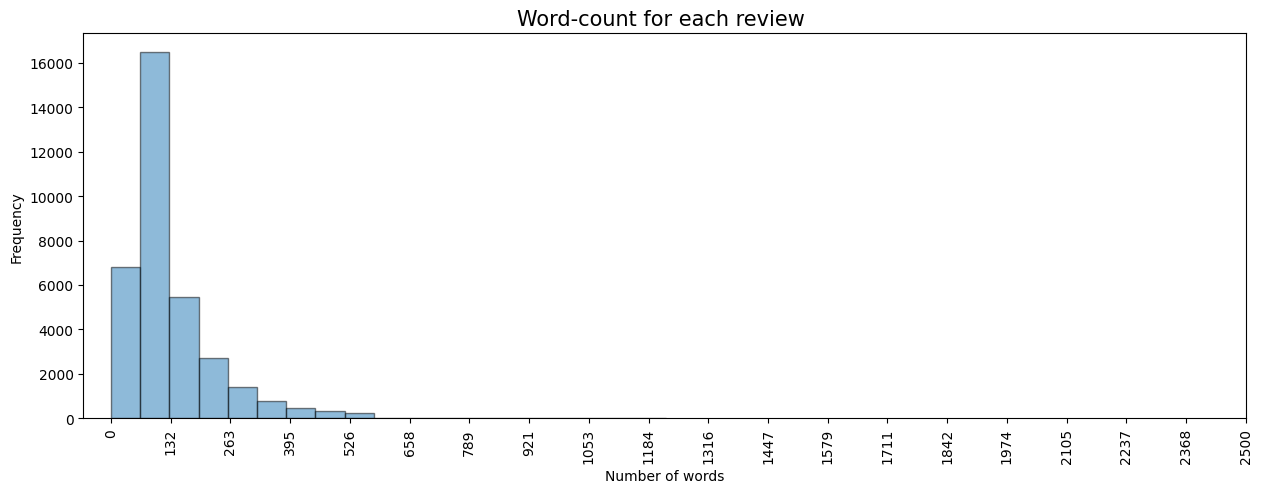

In [29]:
plotting_histogram_for_num_words(num_words_series, plot_threshold=False)

In [30]:
# Encoding the label column
np.unique(y_train)

array(['negative', 'positive'], dtype=object)

In [33]:
lbl_enc = LabelEncoder()
lbl_enc.fit(y_train)
y_train_enc = lbl_enc.transform(y_train)

print(lbl_enc.classes_, "-->", lbl_enc.transform(lbl_enc.classes_))

['negative' 'positive'] --> [0 1]


In [35]:
vectorizer = CountVectorizer(stop_words='english', max_features=int(df_new.shape[0] * 0.7)) 
x_train = vectorizer.fit_transform(cleaned_reviews_series)  # cleaned_reviews_series is the training_data after cleaning the text.
y_train_enc = lbl_enc.transform(y_train)  # here we use transform not fit because we already fit this encoder previously on the same data
x_train.shape  

(34707, 34707)

In [38]:
x_validation = vectorizer.transform(x_valid['review'])
y_valid_enc = lbl_enc.transform(y_valid)

In [42]:
y_test_enc = lbl_enc.transform(y_test)

In [43]:
models = []

models.append(('LogisticRegression', LogisticRegression()))
models.append(('MultinomialNB', MultinomialNB()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))

for name, model in models:
    %time model.fit(x_train, y_train_enc)
    test_pred = model.predict(x_validation)
    print(name ,'Accuracy Score : ',accuracy_score(y_valid_enc, test_pred))
    print(name ,'F1 Score : ',f1_score(y_valid_enc, test_pred, average='weighted'))
    print('-----------------------------------------------------------------------')



CPU times: total: 375 ms
Wall time: 1.92 s
LogisticRegression Accuracy Score :  0.8791851553045583
LogisticRegression F1 Score :  0.8791850373489335
-----------------------------------------------------------------------
CPU times: total: 0 ns
Wall time: 14.2 ms
MultinomialNB Accuracy Score :  0.849435256151674
MultinomialNB F1 Score :  0.8493664403193598
-----------------------------------------------------------------------
CPU times: total: 2min 47s
Wall time: 3min
RandomForest Accuracy Score :  0.8554860830980234
RandomForest F1 Score :  0.85548047002561
-----------------------------------------------------------------------
CPU times: total: 53.7 s
Wall time: 1min
DecisionTreeClassifier Accuracy Score :  0.7307382008874547
DecisionTreeClassifier F1 Score :  0.7307359663151596
-----------------------------------------------------------------------


In [44]:
lr_reg = LogisticRegression()
lr_reg.fit(x_train, y_train_enc)

nb_clf = MultinomialNB()
nb_clf.fit(x_train, y_train_enc)

rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train_enc)

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train_enc)

DecisionTreeClassifier()

In [113]:

def predict(text):
    m = {1:"Positive", 0:"Negative"}
    return m[lr_reg.predict(vectorizer.transform(np.array([data_cleaning.denoise_text(text)])))[0]]        
    

In [114]:
test_cases = {
    "Positive" : [
        "Children are playing in the park.",
        "Lissa has cooked some cookies.",
        "They have planted the water already.",
        "I was eating lunch when you arrived.",
        "Brian is an engineer.",
        "I will be watering the plants tomorrow morning.",
        "The athletes are practicing so hard.",
        "My mother is baking a chocolate cake.",
        "The sun shines brightly in the morning.",
        "Timothy will be staying at home.",
        "The officer arrested the culprits."
    ],
    "Negative" : [
        "That isn't the way to Nashville.",
        "They are not from Ecuador.",
        "He wasn't eating white rice.",
        "We were not sad when he moved away.",
        "They don't practice yoga.",
        "She did not like Bikhram yoga.",
        "He doesn't have to commute to work.",
        "They will not be joining us for dinner tonight.",
        "She won't be attending the Met Gala this year.",
        "These aren't pistachios.",
        "They weren't playing poker."
    ]
}

In [116]:
for tests in test_cases:
    
    actual = tests
    print(f"\t\tACTUAL : {tests} -> {actual}")

    crt_pred = 0
    false_pred = 0
    total = 0       
 
    for text in test_cases[tests]:
        pred = predict(text)
        if pred == actual:crt_pred += 1
        else : false_pred += 1
        total += 1
    print(f"**CORRECT PREDICTED({actual}) => {crt_pred} \
        \n**WRONG PREDICTED({0 if actual == 1 else 1}) => {false_pred} \n**Total => {total}")
    print("*" * 50)  
        


		ACTUAL : Positive -> Positive
**CORRECT PREDICTED(Positive) => 5         
**WRONG PREDICTED(1) => 6 
**Total => 11
**************************************************
		ACTUAL : Negative -> Negative
**CORRECT PREDICTED(Negative) => 4         
**WRONG PREDICTED(1) => 7 
**Total => 11
**************************************************


In [118]:
import pickle

#pickle.dump(vectorizer, open("../models/sentiment_analyzer_vectorizer.pkl", 'wb'))
#pickle.dump(lbl_enc, open("../models/sentiment_analyzer_label_encoder.pkl", 'wb'))
#pickle.dump(clean_text, open("../models/sentiment_analyzer_test_preprocessing.pkl", 'wb'))
#pickle.dump(clf, open("../models/sentiment_analyzer_multinomialNB.pkl", 'wb'))
pickle.dump(predict, open("../models/sentiment_analyzer_lr.pkl", 'wb'))